In [1]:
import os
import sys

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem
from recpack.datasets import Netflix

/Users/jens/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from minipack.scenarios import ProportionalStratifiedStrongGeneralization, StrongGeneralization

In [6]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Summary Statistics for Netflix Dataset

In [7]:
def import_dataset():
    dataset = Netflix(path='../data/')
    dataset.fetch_dataset()
    return dataset

In [8]:
dataset = import_dataset()
data = dataset.load()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 56880037/56880037 [00:44<00:00, 1289994.48it/s]


In [9]:
data.num_active_users

463435

In [10]:
data.num_interactions

56880037

In [11]:
data.num_active_items

17769

In [12]:
data.num_interactions / (data.num_active_users * data.num_active_items)

0.0069072957713412824

### User Statistics (All Data)

In [13]:
data._df.head()

,interactionid,uid,iid,ts
0,0,0,0,1120694400
1,1,1,0,1121644800
2,2,2,0,1121817600
3,3,3,0,1122854400
4,4,4,0,1124236800


In [14]:
interaction_count = data._df.groupby(['uid'])['iid'].count()

In [15]:
# 95% Quantile of Interactions
interaction_count.quantile(0.950)

438.0

95% of the user history legnths fall within the range [0, 438]. We create 5 bins between [0, 440] (rounded up for tidiness), which means we need bin widths of about 88. Since we perform an 80-20% split for test in and test out data. We increase the bin width from 88 to 110 (88/0.8). This ensures that the data to be minimized (test in) has the number of interactions as defined by the bins.

In [16]:
interaction_count.describe()

count    463435.000000
mean        122.735739
std         165.308101
min           5.000000
25%          25.000000
50%          61.000000
75%         157.000000
max       12206.000000
Name: iid, dtype: float64

### User Stratification (All Data)

/Users/jens/.pyenv/versions/3.11.8/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


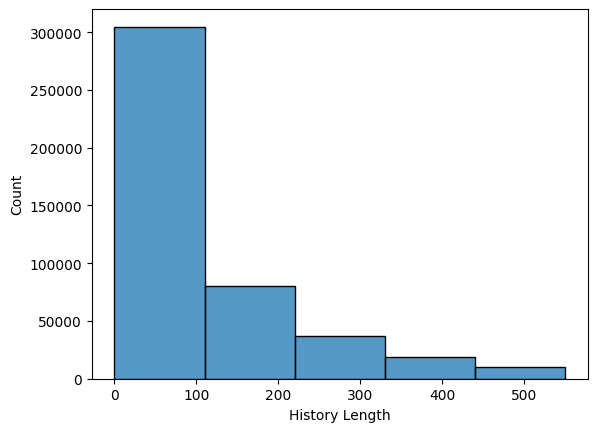

In [17]:
ax = sns.histplot(data=interaction_count, binwidth=110, binrange=[0, 550])
ax.set_ylabel("Count")
ax.set_xlabel("History Length")
plt.show()

In [18]:
# Calculating the number of users in each bin
bin_range = np.arange(0, 551, 110) 

In [19]:
bin_range

array([  0, 110, 220, 330, 440, 550])

In [20]:
# Calculating the number of users in each bin using pd.cut
users_per_bin = pd.cut(interaction_count, bins=bin_range, right=False)
users_per_bin = users_per_bin.value_counts().sort_index()

# Adjusting labels for clarity since the upper limit is exclusive
bin_labels = [f"[{bin_range[i]}, {bin_range[i+1]})" for i in range(len(bin_range)-1)]
users_per_bin.index = bin_labels

# Creating an integer index
# users_per_bin.index = range(len(users_per_bin))

print(users_per_bin)

[0, 110)      304703
[110, 220)     80018
[220, 330)     36951
[330, 440)     18807
[440, 550)      9956
Name: count, dtype: int64


In [21]:
# Generate bin indices and bin ranges
bin_indices = list(range(len(users_per_bin)))
bin_ranges = [f"[{bin_range[i]}, {bin_range[i+1]})" for i in range(len(bin_range)-1)]

# Calculate the total number of elements
total_count = users_per_bin.sum()

# Calculate the fraction of each bin compared to the whole
bin_fractions = users_per_bin / total_count

# Create a dictionary to hold the bin indices, counts, fractions, and ranges
bin_dict = {
    'bindex': bin_indices,
    'bin_range': bin_ranges,
    'bin_fraction': bin_fractions.values
}

# Convert dictionary to DataFrame (optional, if needed for merging later)
bin_df = pd.DataFrame(bin_dict)

print(bin_df)

   bindex   bin_range  bin_fraction
0       0    [0, 110)      0.676464
1       1  [110, 220)      0.177646
2       2  [220, 330)      0.082034
3       3  [330, 440)      0.041753
4       4  [440, 550)      0.022103


### Scenario

In [22]:
scenario = ProportionalStratifiedStrongGeneralization(num_users_test=40000, num_users_val=40000, num_users_est=1000, bin_width=110, bin_range=[0, 550], validation=True, estimation=True, seed=42)
scenario.split(data)

27058it [00:03, 8834.74it/s]
7105it [00:00, 8405.02it/s]
3281it [00:00, 7935.48it/s]
1670it [00:00, 7385.58it/s]
886it [00:00, 7318.86it/s]
40000it [00:04, 8330.11it/s]
676it [00:00, 8974.33it/s]
177it [00:00, 8289.32it/s]
82it [00:00, 7266.85it/s]
41it [00:00, 6085.15it/s]
24it [00:00, 5707.51it/s]


In [23]:
full_train = scenario.full_training_data
val_train = scenario.validation_training_data
val_in = scenario.validation_data_in
val_out = scenario.validation_data_out
test_in = scenario.test_data_in
test_out = scenario.test_data_out
est_in = scenario.estimation_data_in
est_out = scenario.estimation_data_out

In [24]:
data.num_active_users

463435

In [25]:
full_train.num_active_users

423435

In [26]:
val_in.num_active_users

40000

In [27]:
test_in.num_active_users

40000

In [33]:
test_avg_interactions = test_in.num_interactions / test_in.num_active_users
test_avg_interactions

83.57445

In [28]:
est_in.num_active_users

1000

In [29]:
data.num_interactions

56880037

<Axes: xlabel='iid'>

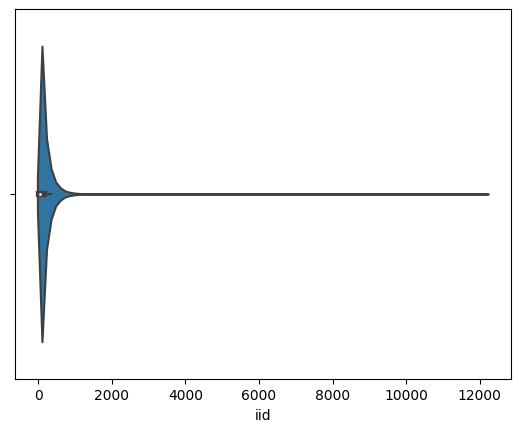

In [30]:
sns.violinplot(x=interaction_count)

### User Stratification (Test Data)

In [31]:
[test_data_bin.num_active_users for test_data_bin in scenario.test_data_in_bins]

[27058, 7105, 3281, 1670, 886]

In [32]:
[test_data_bin.num_interactions / test_data_bin.num_active_users for test_data_bin in scenario.test_data_in_bins]

[32.656996082489464,
 126.49373680506686,
 215.52819262419993,
 303.2814371257485,
 391.62415349887135]